In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Sequential
from keras.layers import Dense,Flatten,BatchNormalization

In [3]:
train_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
train_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


<AxesSubplot:xlabel='label', ylabel='count'>

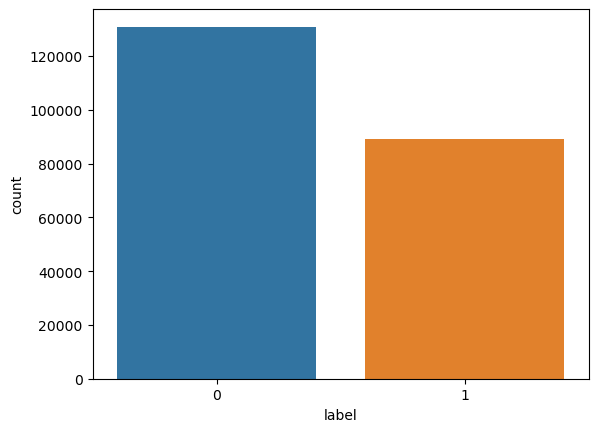

In [4]:
sns.countplot(x=train_df['label'],data=train_df)

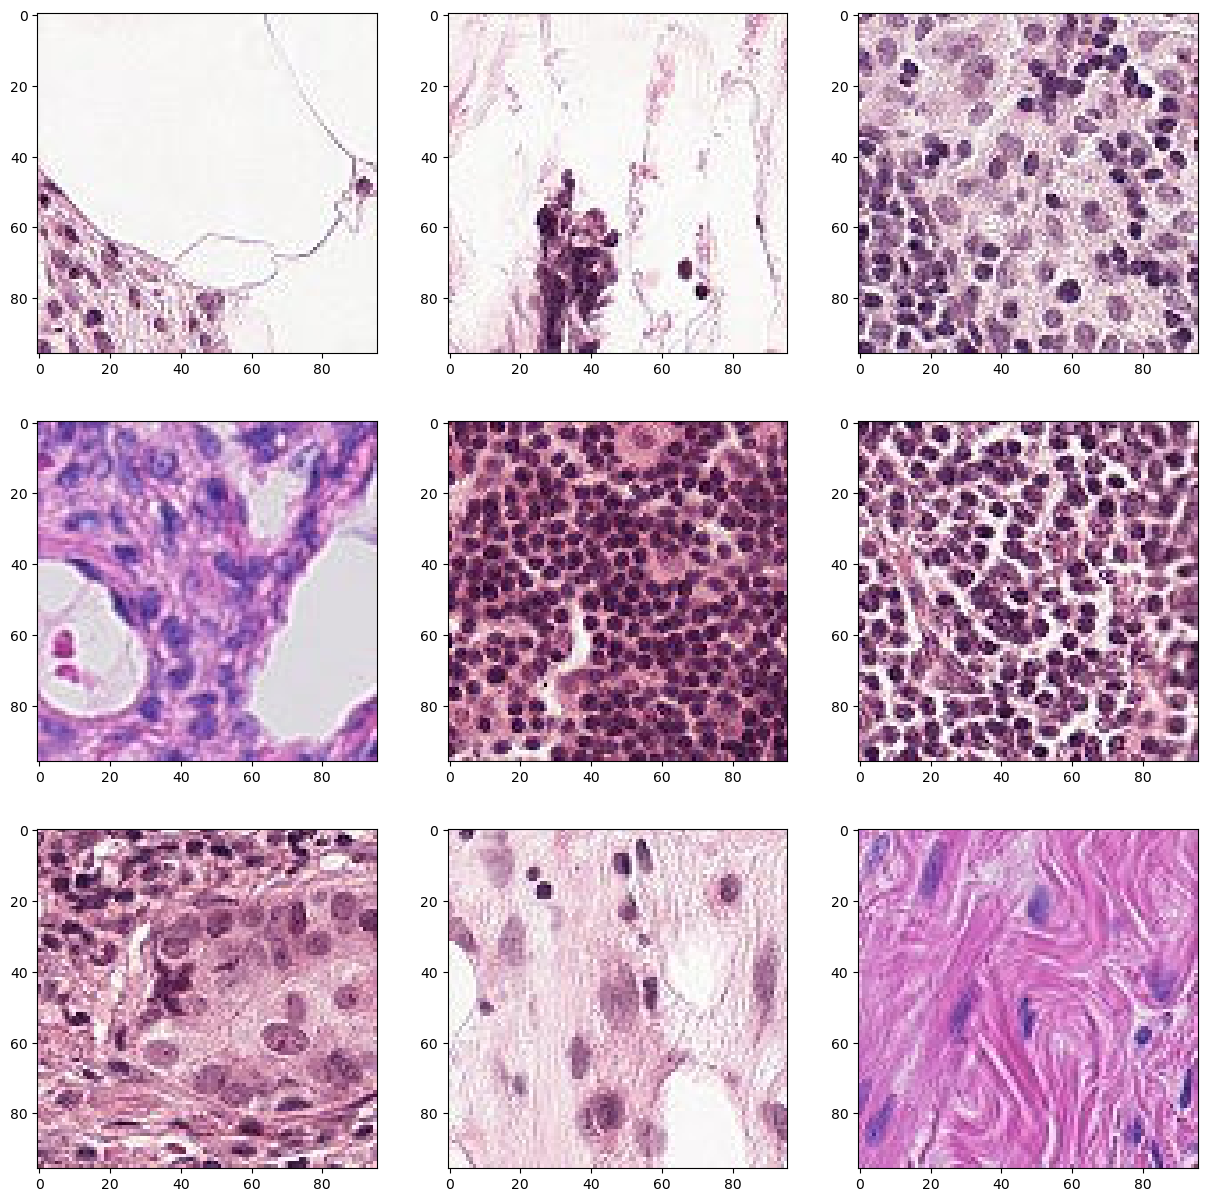

In [5]:
figure,ax = plt.subplots(3,3,figsize=(15,15))

for num,axis in enumerate(ax.flat):
    file_path = "/kaggle/input/histopathologic-cancer-detection/train/" + train_df.id[num] + ".tif"
    image = plt.imread(file_path)
    axis.imshow(image)

In [6]:
file_paths = train_df.id + ".tif"
ds_train = tf.data.Dataset.from_tensor_slices((file_paths,train_df.label))

def read_image(image_file,label):
    image = tf.io.read_file("/kaggle/input/histopathologic-cancer-detection/train"+image_file)
    image = tf.image.decode_image(image,dtype=tf.float32)
    return image, label

In [7]:
ds_train = ds_train.map(read_image).batch(32)

In [8]:
len(ds_train)

6876

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

In [10]:
def append_tif(string):
    string = string + ".tif"
    return string

train_df.id = train_df.id.map(append_tif)
train_df.label = train_df.label.astype(str)

In [11]:
train_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576.tif,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2.tif,0


In [18]:
train_gen = datagen.flow_from_dataframe(directory="/kaggle/input/histopathologic-cancer-detection/train",
                                        dataframe=train_df,
                                       target_size=(64,64),
                                       x_col="id",
                                       y_col="label",
                                       batch_size=256,
                                       subset="training",
                                       class_mode="binary")

Found 220025 validated image filenames belonging to 2 classes.


In [13]:
image = Image.open("/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif")
image = np.array(image)
print(image.shape)

(96, 96, 3)


In [14]:
model = Sequential([
    keras.Input(shape=(64,64,3)),
    layers.Conv2D(kernel_size=3,filters=32,padding="same",activation="relu",kernel_initializer="he_uniform"),
    layers.MaxPooling2D(pool_size=(2,2),strides=2),
    layers.Conv2D(kernel_size=3,filters=64,padding="valid",activation="relu",kernel_initializer="he_uniform"),
    layers.MaxPooling2D(pool_size=(2,2),strides=2),
    layers.Conv2D(kernel_size=3,filters=128,padding="valid",activation="relu",kernel_initializer="he_uniform"),
    Flatten(),
    Dense(10,activation="relu"),
    Dense(1,activation="sigmoid")
])

In [15]:
# model = Sequential([
#     keras.Input(shape=(64,64,3)),
#     layers.Conv2D(32,3,activation="relu"),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64,3,activation="relu"),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128,3,activation="relu"),
#     layers.Flatten(),
#     layers.Dense(10,activation="relu"),
#     layers.Dense(1,activation="sigmoid")
# ])

In [16]:
model.compile(metrics=["accuracy"],optimizer=keras.optimizers.Adam(),loss=keras.losses.binary_crossentropy)

In [20]:
model.fit(train_gen,epochs=1)

860/860 [==============================] - 609s 708ms/step - loss: 0.4670 - accuracy: 0.8023


In [28]:
test_df = pd.DataFrame({'id':os.listdir("/kaggle/input/histopathologic-cancer-detection/test")})
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [35]:
# os.listdir("/kaggle/input/histopathologic-cancer-detection/test")

In [31]:
test_gen = datagen.flow_from_dataframe(directory="/kaggle/input/histopathologic-cancer-detection/test",
                                       dataframe=test_df,
                                         x_col="id",
                                       y_col=None,
                                       class_mode=None,
                                       target_size=(64,64))

Found 57458 validated image filenames.


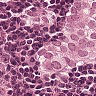

In [23]:
Image.open("/kaggle/input/histopathologic-cancer-detection/test/00006537328c33e284c973d7b39d340809f7271b.tif")

In [37]:
y_test = model.predict(test_gen)

1796/1796 [==============================] - 407s 227ms/step


In [48]:
def mapping(data):
    data_ = []
    for dt in data:
        if dt<0.5:
            dt=0
        else:
            dt=1
        data_.append(dt)
            
    return data_

In [49]:
y_test = mapping(y_test)

In [52]:
test_df['label'] = y_test

In [63]:
test_df.id = test_df["id"].map(lambda x : x.split('.')[0])

In [64]:
test_df.to_csv("submission1.csv",index=False)

In [56]:
sample = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
sample

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0


In [65]:
submission = pd.read_csv("/kaggle/working/submission1.csv")
submission

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,0
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,1
